In [1]:
# This notebook checks MNE functions for ECG and EOG detection
# Cropped data is used here (5 minutes only), tried on whole data - takes forever.


#Load data, make folders
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import configparser
import ancpbids
import plotly
import mpld3

from main_meg_qc import make_derivative_meg_qc, sanity_check, initial_stuff

from data_load_and_folders import load_meg_data, make_folders_meg, Epoch_meg
from RMSE_meq_qc import RMSE_meg_qc
from PSD_meg_qc import PSD_meg_qc
from Peaks_manual_meg_qc import PP_manual_meg_qc
from Peaks_auto_meg_qc import PP_auto_meg_qc
from ECG_meg_qc import ECG_meg_qc
from EOG_meg_qc import EOG_meg_qc
from universal_html_report import keep_fig_derivs, make_joined_report





Opening raw data file /Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds004229/sub-102/meg/sub-102_task-amnoise_meg.fif...
    Read a total of 11 projection items:
        mag.fif : PCA-v1 (1 x 306)  idle
        mag.fif : PCA-v2 (1 x 306)  idle
        mag.fif : PCA-v3 (1 x 306)  idle
        mag.fif : PCA-v4 (1 x 306)  idle
        mag.fif : PCA-v5 (1 x 306)  idle
        mag.fif : PCA-v6 (1 x 306)  idle
        mag.fif : PCA-v7 (1 x 306)  idle
        grad.fif : PCA-v1 (1 x 306)  idle
        grad.fif : PCA-v2 (1 x 306)  idle
        grad.fif : PCA-v3 (1 x 306)  idle
        grad.fif : PCA-v4 (1 x 306)  idle
Opening raw data file /Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds004229/sub-102/meg/sub-102_task-amnoise_meg.fif...
    Read a total of 11 projection items:
        mag.fif : PCA-v1 (1 x 306)  idle
        mag.fif : PCA-v2 (1 x 306)  idle
        mag.fif : PCA-v3 (1 x 306)  idle
        mag.fif : PCA-v4 (1 x 306)  idle
        mag.fif : PCA-v5 (1 x 306)  idle
        

/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/main_meg_qc.py:53: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne.io.read_raw_fif(data_file, allow_maxshield=True, on_split_missing='ignore')


Stimulus channels detected: ['STI001', 'STI002', 'STI003', 'STI004', 'STI005', 'STI006', 'STI007', 'STI008', 'STI101', 'STI201', 'STI301']
Trigger channel has a non-zero initial value of 7936 (consider using initial_event=True to detect this event)
Trigger channel has a non-zero initial value of 3 (consider using initial_event=True to detect this event)
No events with set minimum duration were found using all stimulus channels. No epoching can be done. Try different event duration in config file.


/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:135: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(data, stim_channel=stim_channel, min_duration=event_dur)


RMSE per epoch can not be calculated because no events are present. Check stimulus channel.


Magnetometers
  
Average absolute power per band:
delta 3.6257160956605746e-25
theta 1.883801306849254e-26
alpha 7.454064546525662e-27
beta 1.9880232630183742e-25
gamma 1.662916274398895e-22
  
Average relative power per band:
delta 0.004984072874076916
theta 0.00025102426300867433
alpha 9.756092706727815e-05
beta 0.00295897173370709
gamma 0.9909841556309967
  
Average power/freq per band:
delta 1.2085720318868583e-25
theta 6.2793376894975134e-27
alpha 1.8635161366314155e-27
beta 1.2425145393864839e-26
gamma 2.8185021599981273e-24


Peak-to-Peak per epoch can not be calculated because no events are present. Check stimulus channel.
ECG channel used to identify hearbeats:  ECG063
Average pulse:  50  per minute
Using channel ECG063 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 12000 samples (10.000 sec)

Number of ECG events detected : 1203 (average pulse 67 / min.)
Not setting metadata
1203 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 11)
Loading data for 1203 events and 1201 original time points ...
0 bad epochs dropped
Not setting

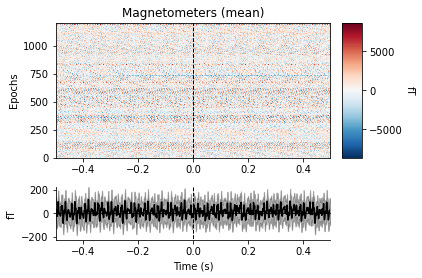

Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 11)
11 projection items activated
SSP projectors applied...


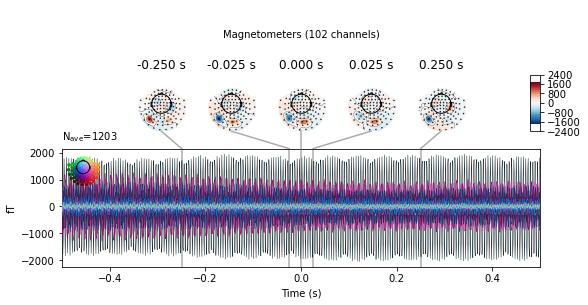

Using EOG channels: EOG061, EOG062
EOG channel index for this subject is: [314 315]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 12000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 186 significant peaks
Number of EOG events detected: 186
Using EOG channels: EOG061, EOG062
EOG channel index for this subject is: [314 315]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameter

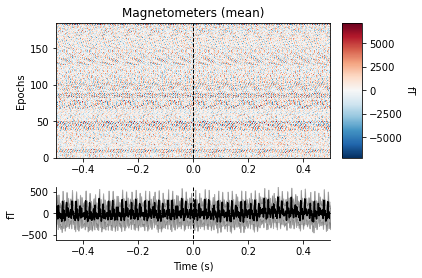

Created an SSP operator (subspace dimension = 11)
11 projection items activated
SSP projectors applied...


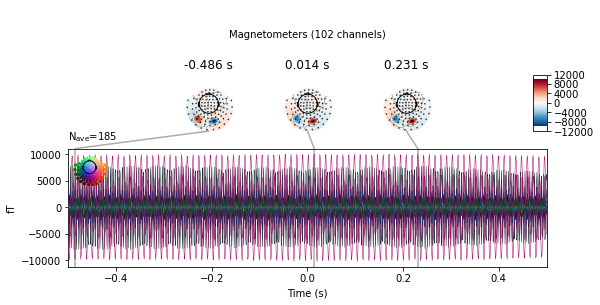

/Users/jenya/opt/anaconda3/envs/mne_new/lib/python3.9/site-packages/mpld3/mplexporter/exporter.py:84: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



In [2]:
#%% TRY TO SAVE DERIVATIVE FROM BIDS DATASET HERE:

config_file_name = 'settings.ini'
make_derivative_meg_qc(config_file_name)


In [ ]:
dict_of_dfs_epoch={'mags': None, 'grads': None}
if dict_of_dfs_epoch['mags'] is None and dict_of_dfs_epoch['grads'] is None:
    print('yes')



In [ ]:

from universal_plots import add_output_format
from universal_html_report import keep_fig_derivs

html_string='''<html>
            #     <head>
            #     <title>HTML File</title>
            #     </head>
            #     <body>
            #     <h1>stuff</h1>
            #     <p>Example stuff</p>
            #     </body>
            #     </html>'''
all_derivs=[(html_string, 'stuff_report', None, 'report')]
all_derivs += [(html_string, 'stuff_report2', None, 'plotly')]

for d in all_derivs:
    if d[3] == 'plotly': #or d[3] == 'matplotlib':
        print(d[3])

all_fig_derivs = keep_fig_derivs(all_derivs)

print(all_fig_derivs)

In [ ]:
# Other useful ancp stuff:

config = configparser.ConfigParser()
config.read('settings.ini')

default_direct = config['DEFAULT']['data_directory']
dataset_path = ancpbids.utils.fetch_dataset(default_direct)

from ancpbids import BIDSLayout
layout = BIDSLayout(dataset_path)

list_of_fifs = layout.get(suffix='meg', extension='.fif', return_type='filename')

list_of_subs = layout.get_subjects()


list_of_entities = layout.get_entities()
print(list_of_entities)

In [ ]:
#TRY SEPARATE FUNCS HERE

config = configparser.ConfigParser()
config.read('settings.ini')
data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif'
dict_of_dfs_epoch, epochs_mg, channels, raw_bandpass, raw_filtered_resampled, raw_cropped, raw = initial_stuff(config, data_file)
m_or_g_chosen = ['mags']
sid='009'
#dfs_ptp_amlitude_annot, bad_channels, amplit_annot_with_ch_names = PP_auto_meg_qc(sid, config, channels, raw, m_or_g_chosen)

#out_with_name_and_format = RMSE_meg_qc(sid, config, channels, dict_of_dfs_epoch, raw_filtered_resampled, m_or_g_chosen)

#out_with_name_and_format = PP_manual_meg_qc(sid, config, channels, dict_of_dfs_epoch, raw_filtered_resampled, m_or_g_chosen)

#out_with_name_and_format = PSD_meg_qc(sid, config, channels, raw_filtered_resampled, m_or_g_chosen)

#out_with_name_and_format = ECG_meg_qc(config, raw, m_or_g_chosen)

out_with_name_and_format = EOG_meg_qc(config, raw, m_or_g_chosen)

#out_with_name_and_format, bad_channels = PP_auto_meg_qc(sid, config, channels, raw_filtered_resampled, m_or_g_chosen)

# psd_section = config['PSD']
# freq_min = psd_section.getfloat('freq_min') 
# freq_max = psd_section.getfloat('freq_max') 
# mean_power_per_band_needed = psd_section.getboolean('mean_power_per_band_needed')
# n_fft = psd_section.getint('n_fft')
# n_per_seg = psd_section.getint('n_per_seg')

# m_or_g='mags'
# fig, fig_desc, fig_path, dfs_with_name = Power_of_freq_meg(ch_names=channels[m_or_g], m_or_g = m_or_g, freqs = freqs[m_or_g], psds = psds[m_or_g], mean_power_per_band_needed = mean_power_per_band_needed, plotflag = True, sid = sid)

#deriv_with_name_and_format = PSD_meg_qc(sid, config, channels, raw_filtered_resampled, m_or_g_chosen)


#figs = ECG_meg_qc(config, raw, m_or_g_chosen)

print(out_with_name_and_format)

In [ ]:
# out_with_name_and_format[0].convert_fig_to_html()
from universal_plots import QC_derivative
dr = QC_derivative('001', 'mean_EC_epoch', None, '')
# dr_html = dr.convert_fig_to_html()
# l=["a"]

# if dr_html is not None:

#     l += dr_html
    
# print(l)

sec = dr.get_section()
print(sec)


In [ ]:
print(figs)
all_fig_derivs = figs
figures_report = {}
for x in range(0, len(all_fig_derivs)):
    if all_fig_derivs[x][3]=='plotly':
        figures_report["f{0}".format(x)] = plotly.io.to_html(all_fig_derivs[x][0])
    elif all_fig_derivs[x][3]=='matplotlib':
        figures_report["f{0}".format(x)] = mpld3.fig_to_html(all_fig_derivs[x][0]);

print(figures_report)

In [ ]:

import mpld3

html_fig=mpld3.fig_to_html(figs[0][0])
print(html_fig)



# file = open('matpl_fig.html', "w")
# file.write(html_fig)
# file.close()

In [ ]:
html_string = '''
<!doctype html>
<html>
    <head>
        <meta charset="UTF-8">
        <title>MEG QC: Frequency spectrum Report</title>
        <style>body{ margin:0 100;}</style>
    </head>
    
    <body style="font-family: Arial">
        <center>
        <h1>MEG data quality analysis report</h1>
        <br></br>
        <!-- *** Section 1 *** --->
        <h2>Frequency spectrum per channel</h2>
        ''' + html_fig + '''
        <p>graph description...</p>
        </center>
    
    </body>
</html>'''

with open('report_trial.html', 'w', encoding = 'utf8') as f:
    f.write(html_string)

In [ ]:
#config = configparser.ConfigParser()
#config.read('settings.ini')

#data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds000117/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_meg.fif'
# file does not start with a file id tag

#data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003392/sub-01/meg/sub-01_task-localizer_meg.fif'
# SSS frilter. need to allow maxshiled.

#data_file ='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003694/sub-01/meg/sub-01_task-MEM_run-01_meg.fif'
#raw = mne.io.read_raw_fif(data_file, on_split_missing='ignore')


#dict_of_dfs_epoch, epochs_mg, channels, raw_bandpass, raw_filtered_resampled, raw_cropped, raw = initial_stuff(config, data_file)

#data_file ='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003922/sub-Mp150285/ses-01/meg/sub-Mp150285_ses-01_acq-crosstalk_meg.fif'
#Could not find measurement data: how many in this set, which subjects?


data_file ='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds004229/sub-102/meg/sub-102_task-amnoise_meg.fif'
#SSS filter
raw = mne.io.read_raw_fif(data_file, allow_maxshield=False)


#data_dir ='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/not fitting no fif/ds000246/sub-0001/meg/sub-0001_task-AEF_run-01_meg.ds'
#raw = mne.io.read_raw_ctf(data_dir)


In [ ]:
raw
# reference channels for ctf systems already implemented (subtracted), is this done automatically by the ctf systems?